# Desafio

## Importar bibliotecas e checar base de dados

In [1]:
import pandas as pd


In [2]:
# Checar as abas da planilha
base = pd.ExcelFile("Base Desafio.xlsx")
print(base.sheet_names)

['Base de clientes', 'Base de receita', 'Base de custódia']


In [3]:
# Ler as abas! obs: como abri antes no sheets e vi que que a receita possui 1 linha inicial em branco ja utilizo o skiprow
clientes = base.parse("Base de clientes")
receita = base.parse("Base de receita", skiprows=1)
custodia = base.parse("Base de custódia")

In [4]:
# Por se tratar de uma tabela com poucas colunas e ter checado antes no excel/sheets ja conheço o nome das colunas e pedi logo para que tudo ficasse sem espaços, acentos e tudo minúsculo para facilitar ainda mais a limpeza e análise
def limpar_colunas(df):
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.normalize('NFKD')
        .str.encode('ascii', errors='ignore')
        .str.decode('utf-8')
        .str.replace(" ", "_")
    )
    return df

clientes = limpar_colunas(clientes)
receita = limpar_colunas(receita)
custodia = limpar_colunas(custodia)

In [5]:
# Quais as primeiras linhas de cada aba? mesmo ja abrindo no sheets sempre bom conferir no código
print("Clientes")
print(clientes.head(), '\n')

print("Receita")
print(receita.head(), '\n') # ja pulando a primeira linha em branco!

print("Custódia")
print(custodia.head(), '\n')

Clientes
    cliente assessor_responsavel inicio_de_relacionamento
0  24431465                A9156               2020-09-27
1  16733019                A7586               2021-08-06
2  52510844                A7586               2023-02-18
3  31360529                A7807               2019-09-17
4  61091111                A2788               2020-06-14 

Receita
         mes   cliente classe_de_ativo      receita
0 2020-10-01  24431465      Renda Fixa  1274.985000
1 2020-10-01  24431465  Renda Variável  2338.983333
2 2020-11-01  24431465      Renda Fixa   618.696667
3 2020-11-01  24431465  Renda Variável  1004.128333
4 2020-12-01  24431465      Renda Fixa   896.013333 

Custódia
         mes   cliente classe_de_ativo  volume_alocado
0 2020-10-01  24431465      Renda Fixa      3960828.42
1 2020-10-01  24431465  Renda Variável      3652849.27
2 2020-11-01  24431465      Renda Fixa      2457243.42
3 2020-11-01  24431465  Renda Variável      1715858.17
4 2020-12-01  24431465      Renda F

## Limpeza de dados

In [6]:
# 1. Renomeando algumas colunas
clientes.rename(columns={
    "assessor_responsavel": "assessor",
    "inicio_de_relacionamento": "data_relacionamento"
    }, inplace=True)

In [7]:
# 2. verificar se tem algo em branco
print("Clientes - Dados faltantes:\n", clientes.isnull().sum(), "\n")
print("Receita - Dados faltantes:\n", receita.isnull().sum(), "\n")
print("Custódia - Dados faltantes:\n", custodia.isnull().sum(), "\n")

# analisei que em uma linha temos o cliente e o mês mas não temos a classe de ativo de volume alocado, manter essa linha pode prejudicar na análise futuramente resolvi limpá-la
custodia.dropna(subset=["classe_de_ativo", "volume_alocado"], inplace=True)

Clientes - Dados faltantes:
 cliente                0
assessor               0
data_relacionamento    0
dtype: int64 

Receita - Dados faltantes:
 mes                0
cliente            0
classe_de_ativo    0
receita            0
dtype: int64 

Custódia - Dados faltantes:
 mes                0
cliente            0
classe_de_ativo    1
volume_alocado     1
dtype: int64 



In [8]:
# 3. Clientes duplicados?
print("Clientes - Duplicados:", clientes.duplicated().sum())
print("Receita - Duplicados:", receita.duplicated().sum())
print("Custódia - Duplicados:", custodia.duplicated().sum())

Clientes - Duplicados: 0
Receita - Duplicados: 0
Custódia - Duplicados: 0


## 1. Análise de Receita e Ticket Médio

In [9]:
# Juntando primeiro a aba de clientes com a aba de receita para que eu possa calcular a relação
receita = receita.merge(clientes[["cliente", "assessor"]], on="cliente", how="left")
receita.head()

,mes,cliente,classe_de_ativo,receita,assessor
0,2020-10-01,24431465,Renda Fixa,1274.985000,A9156
1,2020-10-01,24431465,Renda Variável,2338.983333,A9156
2,2020-11-01,24431465,Renda Fixa,618.696667,A9156
3,2020-11-01,24431465,Renda Variável,1004.128333,A9156
4,2020-12-01,24431465,Renda Fixa,896.013333,A9156


In [10]:
# Receita dos últimos 12 m por assessor
data_max = receita["mes"].max()
data_min = data_max - pd.DateOffset(months=12)
receita_12m = receita[(receita["mes"] > data_min) & (receita["mes"] <= data_max)]
receita_12m.head()

,mes,cliente,classe_de_ativo,receita,assessor
90,2024-07-01,24431465,Renda Fixa,1050.203333,A9156
91,2024-07-01,24431465,Renda Variável,3008.108333,A9156
92,2024-08-01,24431465,Renda Fixa,1545.562500,A9156
93,2024-08-01,24431465,Renda Variável,1395.065833,A9156
94,2024-09-01,24431465,Renda Fixa,576.380833,A9156


In [11]:
# Agrupando agora por asssessor
receita_total = receita_12m.groupby("assessor")["receita"].sum().reset_index()
receita_total.rename(columns={"receita": "receita_total_12m"}, inplace=True)
receita_total.sort_values("receita_total_12m", ascending=False)

# O Assessor A7773 foi o que obtve a maior receita entre os 10 assessores nos últimos 12 meses

,assessor,receita_total_12m
6,A7773,496736.307500
2,A2788,409213.385833
9,A9156,389584.190000
0,A1089,307204.604167
5,A7586,294505.910833
4,A7433,250841.980833
7,A7807,236813.585000
8,A8547,202665.371667
1,A2094,179002.604167
3,A3512,114595.911667


In [12]:
# Qual número total de clientes ativos?
clientes_ativos = custodia["cliente"].unique()
clientes_ativos_df = clientes[clientes["cliente"].isin(clientes_ativos)]
numero_clientes_ativos = len(clientes_ativos_df["cliente"].unique())
print(f"Número total de clientes ativos: {numero_clientes_ativos}")

Número total de clientes ativos: 100


In [13]:
# E qual o número atual de clientes ativos por assessor?
clientes_por_assessor = (
    receita.groupby("assessor")["cliente"]
    .nunique()
    .reset_index()
    .sort_values("cliente", ascending=False)
    .rename(columns={"cliente": "clientes_ativos"})
)
print(clientes_por_assessor)

# Além de ter a maior receita nos últimos 12 meses o assessor A7773 tem o maior número de clientes ativos, possivelmente pode ser a razão de ter a maior receita dentre os assessores

  assessor  clientes_ativos
6    A7773               17
2    A2788               14
9    A9156               14
0    A1089               11
5    A7586               10
4    A7433                9
7    A7807                8
8    A8547                7
1    A2094                6
3    A3512                4


In [14]:
# Associando cliente ao assessor
custodia_com_assessor = custodia.merge(
    clientes[["cliente", "assessor"]],
    on="cliente",
    how="left")
custodia_com_assessor.head()

,mes,cliente,classe_de_ativo,volume_alocado,assessor
0,2020-10-01,24431465,Renda Fixa,3960828.42,A9156
1,2020-10-01,24431465,Renda Variável,3652849.27,A9156
2,2020-11-01,24431465,Renda Fixa,2457243.42,A9156
3,2020-11-01,24431465,Renda Variável,1715858.17,A9156
4,2020-12-01,24431465,Renda Fixa,4047248.41,A9156


In [15]:
# Ticket Médio (estava dividido em mais de 1 célula e resolvi por o código pra ele em uma só)
ticket_medio_por_assessor = (
    custodia_com_assessor.groupby("assessor")
    .agg(
        volume_total=("volume_alocado", "sum"),
        num_clientes=("cliente", "nunique")
    )
    .assign(
        ticket_medio=lambda x: x["volume_total"] / x["num_clientes"]
    )
    .sort_values("ticket_medio", ascending=False)
    .reset_index()
)
print(ticket_medio_por_assessor)

  assessor  volume_total  num_clientes  ticket_medio
0    A7807  1.993346e+09             8  2.491682e+08
1    A9156  3.415575e+09            14  2.439696e+08
2    A8547  1.705282e+09             7  2.436118e+08
3    A7773  4.061874e+09            17  2.389338e+08
4    A7586  2.372794e+09            10  2.372794e+08
5    A2094  1.325881e+09             6  2.209801e+08
6    A1089  2.332782e+09            11  2.120711e+08
7    A2788  2.920416e+09            14  2.086011e+08
8    A3512  8.156479e+08             4  2.039120e+08
9    A7433  1.822226e+09             9  2.024696e+08


In [16]:
# Formatando os números para exibir sem notação científica pois havia esquecido
pd.set_option('display.float_format', '{:,.2f}'.format)
print(ticket_medio_por_assessor)

  assessor     volume_total  num_clientes   ticket_medio
0    A7807 1,993,345,991.23             8 249,168,248.90
1    A9156 3,415,574,599.09            14 243,969,614.22
2    A8547 1,705,282,333.64             7 243,611,761.95
3    A7773 4,061,874,403.83            17 238,933,788.46
4    A7586 2,372,793,633.93            10 237,279,363.39
5    A2094 1,325,880,841.63             6 220,980,140.27
6    A1089 2,332,782,343.61            11 212,071,122.15
7    A2788 2,920,415,527.81            14 208,601,109.13
8    A3512   815,647,922.58             4 203,911,980.65
9    A7433 1,822,226,473.92             9 202,469,608.21


In [17]:
# Destacando apenas os top 3 assessores, mesmo que na linha anterior ja estivesse na ordem
top3_assessores = ticket_medio_por_assessor.nlargest(3, 'ticket_medio')
print(top3_assessores)

  assessor     volume_total  num_clientes   ticket_medio
0    A7807 1,993,345,991.23             8 249,168,248.90
1    A9156 3,415,574,599.09            14 243,969,614.22
2    A8547 1,705,282,333.64             7 243,611,761.95


## 2. Gráfico de Evolução Mensal de Receita por Classe de Ativo

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# Ajuste de data
receita["mes"] = pd.to_datetime(receita["mes"])

In [20]:
# Filtrando apenas os últimos 24 meses
data_max = receita["mes"].max()
data_min = data_max - pd.DateOffset(months=24)
receita_24m = receita[(receita["mes"] > data_min) & (receita["mes"] <= data_max)]
print(receita_24m)

            mes   cliente classe_de_ativo  receita assessor
66   2023-07-01  24431465      Renda Fixa 1,106.68    A9156
67   2023-07-01  24431465  Renda Variável   495.47    A9156
68   2023-08-01  24431465      Renda Fixa 1,643.62    A9156
69   2023-08-01  24431465  Renda Variável 1,458.54    A9156
70   2023-09-01  24431465      Renda Fixa   919.91    A9156
...         ...       ...             ...      ...      ...
8735 2025-04-01  65624938  Renda Variável 2,724.98    A2788
8736 2025-05-01  65624938      Renda Fixa 1,390.26    A2788
8737 2025-05-01  65624938  Renda Variável 1,999.93    A2788
8738 2025-06-01  65624938      Renda Fixa    50.88    A2788
8739 2025-06-01  65624938  Renda Variável 3,673.94    A2788

[4634 rows x 5 columns]


In [21]:
# Gerando variável de evolução mensal para o gráfico
evolucao_mensal = receita_24m.groupby(["mes", "classe_de_ativo"])["receita"].sum().reset_index()
print(evolucao_mensal)

          mes classe_de_ativo    receita
0  2023-07-01      Renda Fixa  57,743.50
1  2023-07-01  Renda Variável 138,654.49
2  2023-08-01      Renda Fixa  63,419.60
3  2023-08-01  Renda Variável 122,288.64
4  2023-09-01      Renda Fixa  74,521.80
5  2023-09-01  Renda Variável 147,533.78
6  2023-10-01      Renda Fixa  69,350.29
7  2023-10-01  Renda Variável 156,887.57
8  2023-11-01      Renda Fixa  78,311.97
9  2023-11-01  Renda Variável 155,496.84
10 2023-12-01      Renda Fixa  70,004.87
11 2023-12-01  Renda Variável 153,995.94
12 2024-01-01      Renda Fixa  74,297.64
13 2024-01-01  Renda Variável 144,437.58
14 2024-02-01      Renda Fixa  70,346.93
15 2024-02-01  Renda Variável 154,754.52
16 2024-03-01      Renda Fixa  81,332.41
17 2024-03-01  Renda Variável 165,880.40
18 2024-04-01      Renda Fixa  76,054.81
19 2024-04-01  Renda Variável 151,413.35
20 2024-05-01      Renda Fixa  86,385.84
21 2024-05-01  Renda Variável 145,178.35
22 2024-06-01      Renda Fixa  78,283.31
23 2024-06-01  R

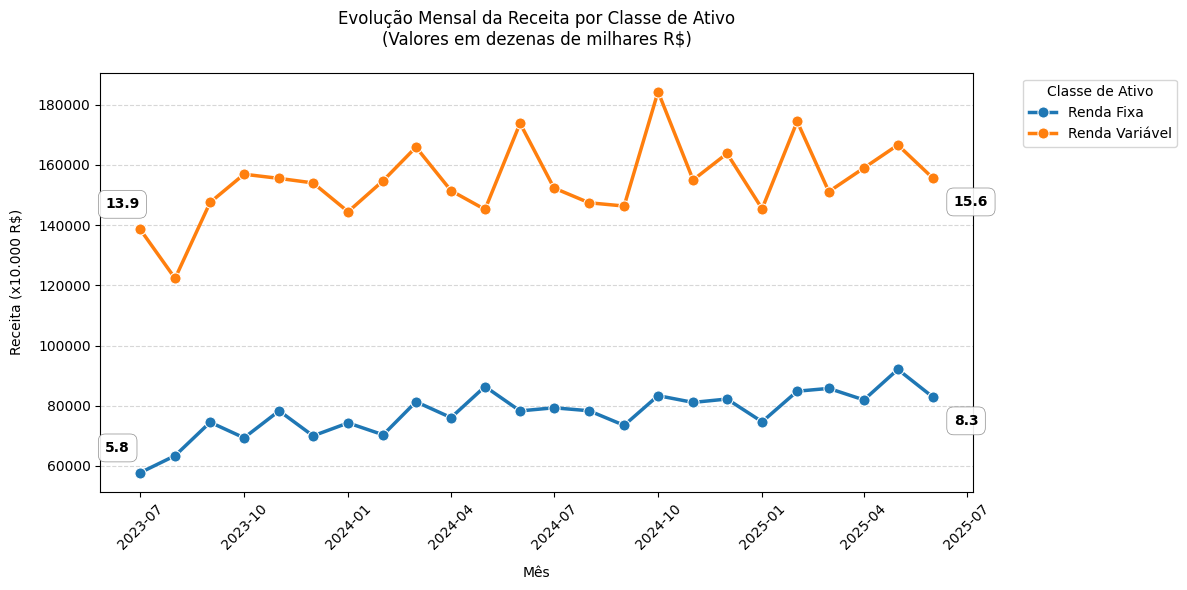

In [22]:
# Gráfico!
plt.figure(figsize=(12,6))
ax = sns.lineplot(
    data=evolucao_mensal, 
    x="mes", 
    y="receita", 
    hue="classe_de_ativo", 
    marker="o", 
    linewidth=2.5,
    markersize=8
)

# Rótulos (quero mostrar os primeiros e últimos valores de cada)
for classe in evolucao_mensal['classe_de_ativo'].unique():
    dados_classe = evolucao_mensal[evolucao_mensal['classe_de_ativo'] == classe].sort_values('mes')
    
    # Primeiro valor
    primeiro = dados_classe.iloc[0]
    ax.annotate(
        f'{primeiro["receita"]/1e4:,.1f}', 
        (primeiro["mes"], primeiro["receita"]),
        xytext=(-25, 15), 
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', lw=0.5, alpha=0.9)
    )
    
    # Último valor
    ultimo = dados_classe.iloc[-1]
    ax.annotate(
        f'{ultimo["receita"]/1e4:,.1f}', 
        (ultimo["mes"], ultimo["receita"]),
        xytext=(15, -20),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', lw=0.5, alpha=0.9)
    )

plt.title("Evolução Mensal da Receita por Classe de Ativo\n(Valores em dezenas de milhares R$)", pad=20)
plt.xlabel("Mês", labelpad=10)
plt.ylabel("Receita (x10.000 R$)", labelpad=10)  # Rótulo corrigido
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Classe de Ativo', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [23]:
# Calcular o crescimento percentual por classe de ativo
crescimento = (
    evolucao_mensal.groupby('classe_de_ativo')['receita']
    .apply(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)
    .round(1)
    .sort_values(ascending=False)
)

# Visualização
print("Crescimento Percentual por Classe de Ativo:")
print(crescimento.to_string())

# Classe com maior crescimento
print(f"\nA classe que mais cresceu foi 'Renda Fixa' com 43.5% de aumento")

Crescimento Percentual por Classe de Ativo:
classe_de_ativo
Renda Fixa       43.50
Renda Variável   12.20

A classe que mais cresceu foi 'Renda Fixa' com 43.5% de aumento


## 3. Bese de Clientes por perfil

### A) Quantos clientes private existem?

In [24]:
# agrupando para saber o volume por cliente
volume_por_cliente = custodia.groupby("cliente")["volume_alocado"].sum().reset_index()

# criando nova coluna para saber os privates
volume_por_cliente["perfil"] = volume_por_cliente["volume_alocado"].apply(
    lambda x: "Private" if x >= 3_000_000 else "Outros"
)
print(volume_por_cliente)

# volume + assessor (juntando dados)
clientes_com_volume = clientes.merge(volume_por_cliente, on="cliente", how="left")
print(clientes_com_volume)

     cliente  volume_alocado   perfil
0   10616501  105,245,776.20  Private
1   12216212  342,467,582.33  Private
2   12919415  264,478,273.48  Private
3   15715945  311,126,108.96  Private
4   16308246  354,938,876.38  Private
..       ...             ...      ...
95  96437183  230,225,992.38  Private
96  97741849  261,758,516.21  Private
97  98385945  235,504,419.21  Private
98  99521384  163,803,942.53  Private
99  99717708  379,031,550.77  Private

[100 rows x 3 columns]
     cliente assessor data_relacionamento  volume_alocado   perfil
0   24431465    A9156          2020-09-27  287,753,625.62  Private
1   16733019    A7586          2021-08-06  261,923,679.27  Private
2   52510844    A7586          2023-02-18  140,841,967.48  Private
3   31360529    A7807          2019-09-17  353,107,614.41  Private
4   61091111    A2788          2020-06-14  338,522,487.27  Private
..       ...      ...                 ...             ...      ...
95  20444953    A9156          2022-02-20  182,930,

In [25]:
# Resposta com quantidade de clientes Private
qtd_private = clientes_com_volume[clientes_com_volume["perfil"] == "Private"]["cliente"].nunique()
print("Quantidade de clientes Private:", qtd_private)

Quantidade de clientes Private: 100


### B) Qual assessor tem mais clientes desse perfil?

In [26]:
private_por_assessor = clientes_com_volume[clientes_com_volume["perfil"] == "Private"]
mais_private = private_por_assessor["assessor"].value_counts().reset_index().iloc[0]
print(f"Assessor com mais clientes Private: {mais_private['assessor']} ({mais_private['count']} clientes)")

Assessor com mais clientes Private: A7773 (17 clientes)


### C) Qual a receita média gerada por esses clientes?

In [27]:
#Lista dos Clientes private e receita
clientes_private = private_por_assessor["cliente"].unique()
receita_private = receita[receita["cliente"].isin(clientes_private)]
print(receita_private)

            mes   cliente classe_de_ativo  receita assessor
0    2020-10-01  24431465      Renda Fixa 1,274.98    A9156
1    2020-10-01  24431465  Renda Variável 2,338.98    A9156
2    2020-11-01  24431465      Renda Fixa   618.70    A9156
3    2020-11-01  24431465  Renda Variável 1,004.13    A9156
4    2020-12-01  24431465      Renda Fixa   896.01    A9156
...         ...       ...             ...      ...      ...
8735 2025-04-01  65624938  Renda Variável 2,724.98    A2788
8736 2025-05-01  65624938      Renda Fixa 1,390.26    A2788
8737 2025-05-01  65624938  Renda Variável 1,999.93    A2788
8738 2025-06-01  65624938      Renda Fixa    50.88    A2788
8739 2025-06-01  65624938  Renda Variável 3,673.94    A2788

[8740 rows x 5 columns]


In [28]:
# Receita Média de clientes private
media_receita = receita_private.groupby("cliente")["receita"].sum().mean()
print(f"Receita média gerada por cliente Private: R$ {media_receita:,.2f}")

Receita média gerada por cliente Private: R$ 106,342.73


## 4. Clientes com Receita Decrescente

In [29]:
# Juntar os 4 últimos meses e criar um filtro para esses meses
ultimos_4_meses = receita["mes"].sort_values().unique()[-4:]
receita_ultimos4 = receita[receita["mes"].isin(ultimos_4_meses)]
print(receita_ultimos4)

            mes   cliente classe_de_ativo  receita assessor
106  2025-03-01  24431465      Renda Fixa   362.47    A9156
107  2025-03-01  24431465  Renda Variável 2,119.87    A9156
108  2025-04-01  24431465      Renda Fixa   232.02    A9156
109  2025-04-01  24431465  Renda Variável 2,003.29    A9156
110  2025-05-01  24431465      Renda Fixa   263.02    A9156
...         ...       ...             ...      ...      ...
8735 2025-04-01  65624938  Renda Variável 2,724.98    A2788
8736 2025-05-01  65624938      Renda Fixa 1,390.26    A2788
8737 2025-05-01  65624938  Renda Variável 1,999.93    A2788
8738 2025-06-01  65624938      Renda Fixa    50.88    A2788
8739 2025-06-01  65624938  Renda Variável 3,673.94    A2788

[800 rows x 5 columns]


In [30]:
# receita por cliente + mês
receita_mensal = receita_ultimos4.groupby(["cliente", "mes"])["receita"].sum().reset_index()
print(receita_mensal)

      cliente        mes  receita
0    10616501 2025-03-01 3,146.98
1    10616501 2025-04-01 3,927.87
2    10616501 2025-05-01   659.00
3    10616501 2025-06-01 3,816.99
4    12216212 2025-03-01 2,481.43
..        ...        ...      ...
395  99521384 2025-06-01 2,850.53
396  99717708 2025-03-01 3,969.71
397  99717708 2025-04-01 2,336.84
398  99717708 2025-05-01 2,844.24
399  99717708 2025-06-01 4,874.08

[400 rows x 3 columns]


In [31]:
# Tabela

# relação de meses para cada coluna
receita_pivot = receita_mensal.pivot(index="cliente", columns="mes", values="receita")

# ordenando por data
receita_pivot = receita_pivot.sort_index(axis=1)

# função
def caiu_3x(linha):
    return all(
        linha.iloc[i] > linha.iloc[i + 1]
        for i in range(len(linha) - 1)
    )
clientes_em_queda = receita_pivot[receita_pivot.apply(caiu_3x, axis=1)].reset_index()

# assessor responsável
clientes_em_queda = clientes_em_queda.merge(clientes[["cliente", "assessor"]], on="cliente", how="left")

print(clientes_em_queda)

# obs: aqui resolvi usar o plotly e também fazer mais a frente um gráfico para melhor visualização

    cliente  2025-03-01 00:00:00  2025-04-01 00:00:00  2025-05-01 00:00:00  \
0  41304314             4,208.70             3,059.43             1,893.04   
1  61451925             3,413.61             2,721.06             1,345.72   
2  82100173             3,706.98             2,940.26             1,964.15   

   2025-06-01 00:00:00 assessor  
0             1,759.83    A2788  
1               685.14    A7433  
2             1,689.08    A7433  


In [32]:
# Tabela com Plotly

import plotly.graph_objects as go

dados_formatados = [
    clientes_em_queda["cliente"],
    clientes_em_queda["assessor"]
]

for col in receita_pivot.columns:
    dados_formatados.append(clientes_em_queda[col].map(lambda x: f"R$ {x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')))

# Cabeçalhos
header_vals = ["Cliente", "Assessor"] + [col.strftime('%b/%Y') for col in receita_pivot.columns]

# Cores
header_color = '#0B1C39'
cell_color = '#E5ECF6'
font_color = 'white'

# Criando a tabela
fig = go.Figure(data=[go.Table(
    header=dict(
        values=header_vals,
        fill_color=header_color,
        font=dict(color=font_color, size=13),
        align='left'
    ),
    cells=dict(
        values=dados_formatados,
        fill_color=cell_color,
        align='left'
    )
)])

fig.update_layout(width=1100, height=400)
fig.show()

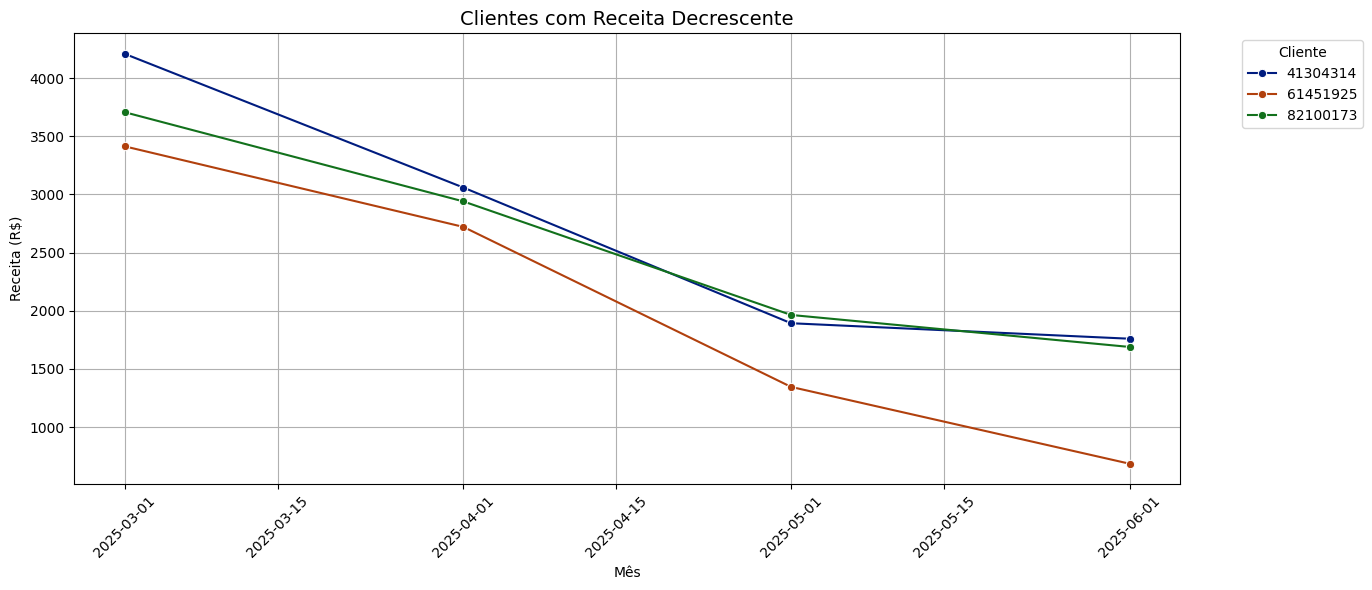

In [33]:
# Gráfico com Seaborn

# Reorganizando os dados
dados_plot = clientes_em_queda.melt(
    id_vars=["cliente", "assessor"],
    value_vars=receita_pivot.columns,
    var_name="mes",
    value_name="receita"
)

# Ordenando os meses
dados_plot["mes"] = pd.to_datetime(dados_plot["mes"])
dados_plot = dados_plot.sort_values("mes")

# Criando o gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(data=dados_plot, x="mes", y="receita", hue="cliente", marker="o", palette="dark")

plt.title("Clientes com Receita Decrescente", fontsize=14)
plt.xlabel("Mês")
plt.ylabel("Receita (R$)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title="Cliente", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()



## Automação - Desafio bônus

In [34]:
# Código completo para geração de relatórios com logo e dados em tabela:

In [35]:
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
import os
from zipfile import ZipFile
from fpdf import FPDF

# CARREGAR BASES DO EXCEL
clientes = pd.read_excel("base_desafio_limpa.xlsx", sheet_name="clientes")
receita = pd.read_excel("base_desafio_limpa.xlsx", sheet_name="receita")
custodia = pd.read_excel("base_desafio_limpa.xlsx", sheet_name="custodia")

# TRATAR E UNIFICAR DADOS
dados = pd.merge(receita, custodia, on=["cliente", "mes", "classe_de_ativo"], how="outer")
dados = pd.merge(dados, clientes[["cliente", "assessor"]], on="cliente", how="left")

# Agrupar dados por cliente, mês e assessor
dados_agrupados = dados.groupby(["cliente", "assessor", "mes"]).agg({
    "volume_alocado": "sum",
    "receita": "sum"
}).reset_index()

# GERAR RELATÓRIOS PDF
os.makedirs("relatorios", exist_ok=True)

for cliente_id in dados_agrupados["cliente"].unique():
    df_cliente = dados_agrupados[dados_agrupados["cliente"] == cliente_id]
    if df_cliente.empty:
        continue

    assessor = df_cliente["assessor"].iloc[0]
    nome_arquivo = f"relatorios/Relatorio_{cliente_id}.pdf"

    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)

    
    # Título
    pdf.set_font("Arial", 'B', 16)
    pdf.set_text_color(19, 56, 84)
    pdf.cell(0, 10, f"Relatório do Cliente {cliente_id}", ln=True)

    # Assessor
    pdf.set_font("Arial", '', 12)
    pdf.set_text_color(0, 0, 0)
    pdf.cell(0, 10, f"Assessor Responsável: {assessor}", ln=True)

    pdf.ln(5)
    pdf.set_font("Arial", 'B', 12)
    pdf.set_fill_color(19, 56, 84)
    pdf.set_text_color(255, 255, 255)

    pdf.cell(40, 10, "Mês", border=1, fill=True)
    pdf.cell(60, 10, "Volume Alocado (R$)", border=1, fill=True)
    pdf.cell(60, 10, "Receita (R$)", border=1, fill=True)
    pdf.ln()

    pdf.set_font("Arial", '', 12)
    pdf.set_text_color(0, 0, 0)

    for _, row in df_cliente.iterrows():
        mes_formatado = pd.to_datetime(row["mes"]).strftime("%Y-%m")
        vol = f"R$ {row['volume_alocado']:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
        rec = f"R$ {row['receita']:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
        pdf.cell(40, 10, mes_formatado, border=1)
        pdf.cell(60, 10, vol, border=1)
        pdf.cell(60, 10, rec, border=1)
        pdf.ln()

    pdf.output(nome_arquivo)

# COMPACTAR EM .ZIP
with ZipFile("relatorios_clientes.zip", "w") as zipf:
    for root, dirs, files in os.walk("relatorios"):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

print("Relatórios gerados e compactados com sucesso!")

Relatórios gerados e compactados com sucesso!
